# How to win League of Legends?

#### The following notebook shows the results of our joint work on the Machine Learning Course Final Project

### What is League of Legends?

From Wikipedia:

League of Legends is a 2009 multiplayer online battle arena video game developed and published by Riot Games.

In the game, two teams of five players battle in player versus player combat, with each team occupying and defending their own half of the map. Each of the ten players controls a character, known as a "champion", with unique abilities and differing styles of play. During a match, champions become more powerful by collecting experience points and purchasing items in order to defeat the opposing team. In the game's main mode, Summoner's Rift, a team wins by pushing through to the enemy base and destroying their "nexus", a large structure located within it.

Teams consist of five unique roles, TOP, JUNGLE, MID, ADC, SUPPORT. As features, we used 3 basic variables for each role in both teams. Unfortunately, initially the datasets had completely permuted roles, so we had to segregate (based on the meta, i.e. the frequency of playing team-comps) featurings to specific roles.

## Our goal

We wanted to create a model that would be able to judge the final result of the match from the match statistics from the 10th minute of the game, ava. As data, we used 90 features 45 per team.

The average length of a game in LoL is about 35 minutes, so we want to try to predict the result in less than 1/3 of the match!

## Data 

More about data in the second notebook.

## Data collecting

We collected data using a hand-written Python class that creates datasets using the [API](https://developer.riotgames.com/) provided by Riot Games. More info about data collecting proccess in the rest of the repository.

## INIT

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import sklearn.preprocessing

from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

### Getting data

In [2]:
df = pd.read_csv('eun1_DIAMOND_RANKED_SOLO_BEST.csv')
df.head(10)

,match_id,1_win,1_firstDragon,1_MIDDLE_xp_per_min,1_MIDDLE_creeps_per_min,1_MIDDLE_gold_per_min,1_MIDDLE_damage_taken_per_min,1_MIDDLE_first_blood,1_MIDDLE_first_blood_assist,1_MIDDLE_first_tower,...,2_MIDDLE_champion_name,2_MIDDLE_champion_attribute,2_TOP_champion_name,2_TOP_champion_attribute,2_JUNGLE_champion_name,2_JUNGLE_champion_attribute,2_SUPPORT_champion_name,2_SUPPORT_champion_attribute,2_ADC_champion_name,2_ADC_champion_attribute
0,2725511175,True,False,410.5,7.4,293.4,430.0,True,False,False,...,Kalista,Marksman,Viego,Assassin,Graves,Marksman,Janna,Support,Aphelios,Marksman
1,2710306824,False,True,465.0,7.1,328.0,450.8,False,False,False,...,Tristana,Marksman,Fiora,Fighter,Fiddlesticks,Mage,Senna,Marksman,Tahm Kench,Support
2,2677276686,False,True,437.9,5.5,354.6,578.9,False,False,False,...,Orianna,Mage,Darius,Fighter,Olaf,Fighter,Soraka,Support,Kalista,Marksman
3,2713845795,True,True,403.3,5.7,270.3,426.6,False,False,False,...,Viktor,Mage,Renekton,Fighter,Yone,Assassin,Vel'Koz,Mage,Rengar,Assassin
4,2596012070,False,False,444.0,7.2,276.0,294.8,False,False,False,...,Rumble,Fighter,Sett,Fighter,Rammus,Tank,Pyke,Support,Ezreal,Marksman
5,2696413232,False,True,445.4,7.1,238.4,277.6,False,False,False,...,Syndra,Mage,Sion,Tank,Rek'Sai,Fighter,Thresh,Support,Vayne,Marksman
6,2704146490,False,False,386.0,4.4,280.6,490.4,True,False,False,...,Yasuo,Fighter,Vladimir,Mage,Taliyah,Mage,Seraphine,Mage,Jhin,Marksman
7,2718302283,False,False,504.6,7.4,337.0,405.8,True,False,False,...,Mordekaiser,Fighter,Irelia,Fighter,Kha'Zix,Assassin,Yuumi,Support,Kai'Sa,Marksman
8,2709258316,True,True,473.8,7.6,272.2,402.5,False,False,False,...,Quinn,Marksman,Yone,Assassin,Evelynn,Assassin,Karma,Mage,Jhin,Marksman
9,2713714766,False,False,442.5,6.5,327.4,319.4,False,False,False,...,Viego,Assassin,Malphite,Tank,Shen,Tank,Morgana,Mage,Samira,Marksman


### Data pre-processing

In [3]:
champion_attribute_feats = [col for col in df.columns if col.endswith('champion_attribute')]

onehotencoder = OneHotEncoder()

attributes_encoding = onehotencoder.fit_transform(df[champion_attribute_feats]).toarray()

to_drop_feats = [col for col in df.columns if col.endswith('champion_attribute') or col.endswith('champion_name')]

df = df.drop(columns = to_drop_feats)

df = pd.concat([df, pd.DataFrame(attributes_encoding, index=df.index)], axis=1)

In [4]:
df.iloc[:,1] = df.iloc[:,1] == 1 # We need classes to classifiers (NIE WIEM CZY TO POTRZEBNA)

In [5]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns = df.columns)

In [6]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

In [321]:
# get train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

0.0    5064
1.0    5029
Name: 1_win, dtype: int64


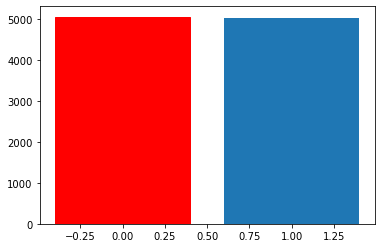

In [322]:
counts = y.value_counts()
print(counts)
b = plt.bar(counts.index, counts.values)
b[0].set_color('r')
plt.show()

As we can see, the distribution of the target value is very balanced, so the assessment of the model by ordinary accuracy is reliable

### Early results

In [323]:
clfs = {
    'SVC': SVC(probability=True),
    'Logistic Regression': LogisticRegression(),
    'Ridge Regression': RidgeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False),
    'AdaBoost': AdaBoostClassifier(),
    'Bernouli Naive Bayes': BernoulliNB(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Multinomial Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(),
}
clfs_acc = {}
clfs_props = {}
clfs_preds ={}

We wanted to try our data on few pure classifiers with defalut settings.
Here are our early results:

In [324]:
print('{:^23} | {:^10}'.format('Model', 'Accuracy'))
for (clf_n, clf) in clfs.items():
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    clfs_acc[clf_n] = acc
    print('{:^23} | {:^10.2f}'.format(clf_n, acc))

         Model          |  Accuracy 
          SVC           |    0.71   


/home/maurykdell/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Logistic Regression   |    0.71   
   Ridge Regression     |    0.71   
[19:06:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
        XGBoost         |    0.67   
       AdaBoost         |    0.70   
 Bernouli Naive Bayes   |    0.69   
 Gaussian Naive Bayes   |    0.69   
Multinomial Naive Bayes |    0.70   
          KNN           |    0.59   
          MLP           |    0.63   


/home/maurykdell/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


As we can see, the early results are satisfactory (~0.7 acc), but let's try to improve them by tuning hyperparameters, e.g. Grid-Search.

## Hyperparameteres tuning

SVC

In [11]:
# SVC parameters tuning by Grid Search
params = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
    'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000],
    'probability': [True]
}
clf = GridSearchCV(SVC(), params, cv=5, scoring='accuracy', n_jobs=12)
clf.fit(X_train, y_train)

print("Best parameters on testing set:")
print(clf.best_params_)

Best parameters on testing set:
{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}


In [332]:
# Updating SVC
model = SVC()
model.set_params(**clf.best_params_)
clfs['SVC'] = model
clfs['SVC'].fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('SVC update:\nold accuracy: {} new accuracy: {}'.format(clfs_acc['SVC'], acc))

clfs_preds['SVC'] = model.predict(X_train)
clfs_props['SVC'] = model.predict_proba(X_train)

SVC update:
old accuracy: 0.7054161162483488 new accuracy: 0.7113606340819022


Logistic Regression

In [325]:
# Logistic Regression parameters tuning by Grid Search
params_grid = {
    'C': [0.001, 0.01, 0.1, 1., 10., 100., 1000.]
}
clf = GridSearchCV(LogisticRegression(max_iter=1000), params_grid, cv=5, scoring='accuracy', n_jobs=12)
clf.fit(X_train, y_train)

print("Best parameters on testing set:")
print(clf.best_params_)

Best parameters on testing set:
{'C': 1.0}


In [326]:
# Updating Logistic Regression
model = LogisticRegression()
model.set_params(**clf.best_params_)
clfs['Logistic Regression'] = model
clfs['Logistic Regression'].fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('Logistic Regression update:\nold accuracy: {} new accuracy: {}'.format(clfs_acc['Logistic Regression'], acc))

clfs_preds['Logistic Regression'] = model.predict(X_train)
clfs_props['Logistic Regression'] = model.predict_proba(X_train)

Logistic Regression update:
old accuracy: 0.7060766182298547 new accuracy: 0.7060766182298547


/home/maurykdell/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ridge Regression

In [333]:
# Ridge Regression parameters tuning by Grid Search
params_grid = {
    'alpha': [0.,0.00001,0.0001,0.001,0.01,0.1,1.0,10.,100.] , 
    'fit_intercept': [True, False],
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
clf = GridSearchCV(RidgeClassifier(), params_grid, cv=5, scoring='accuracy', n_jobs=12)
clf.fit(X_train, y_train)

print("Best parameters on testing set:")
print(clf.best_params_)

Best parameters on testing set:
{'alpha': 10.0, 'fit_intercept': False, 'solver': 'lsqr'}


In [334]:
# Updating Ridge Regression
model = RidgeClassifier()
model.set_params(**clf.best_params_)
clfs['Ridge Regression'] = model
clfs['Ridge Regression'].fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('Ridge Regression update:\nold accuracy: {} new accuracy: {}'.format(clfs_acc['Ridge Regression'], acc))

tmp = model.predict(X_train)
clfs_preds['Ridge Regression'] = tmp
clfs_props['Ridge Regression'] = np.column_stack((tmp,1-tmp))

Ridge Regression update:
old accuracy: 0.7087186261558784 new accuracy: 0.7100396301188904


Ada Boost

In [327]:
# Ada Boost parameters tuning by Grid Search
params_grid = {
    'algorithm': ['SAMME'],
    'n_estimators': [10,50,100,150,200,300,500,700,800],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
    }
clf = GridSearchCV(AdaBoostClassifier(), params_grid, cv=5, scoring='accuracy', n_jobs=12)
clf.fit(X_train, y_train)

print("Best parameters on testing set:")
print(clf.best_params_)

Best parameters on testing set:
{'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 800}


In [328]:
# Updating Ada Boost
model = AdaBoostClassifier(algorithm='SAMME')
model.set_params(**clf.best_params_)
clfs['AdaBoost'] = model
clfs['AdaBoost'].fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('Ada Boost update:\nold accuracy: {} new accuracy: {}'.format(clfs_acc['AdaBoost'], acc))

clfs_preds['AdaBoost'] = model.predict(X_train)
clfs_props['AdaBoost'] = model.predict_proba(X_train)

Ada Boost update:
old accuracy: 0.6961690885072656 new accuracy: 0.7007926023778072


Bernoulli (Naive Bayes)

In [335]:
# Bernoulli (Naive Bayes) parameters tuning by Grid Search
params_grid = {'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]}
clf = GridSearchCV(BernoulliNB(), params_grid, cv=5, scoring='accuracy', n_jobs=12)
clf.fit(X_train, y_train)

print("Best parameters on testing set:")
print(clf.best_params_)

Best parameters on testing set:
{'alpha': 1e-10}


In [336]:
# Updating BernoulliNB
model = BernoulliNB()
model.set_params(**clf.best_params_)
clfs['Bernouli Naive Bayes'] = model
clfs['Bernouli Naive Bayes'].fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('Bernouli Naive Bayes update:\nold accuracy: {} new accuracy: {}'.format(clfs_acc['Bernouli Naive Bayes'], acc))

clfs_preds['Bernouli Naive Bayes'] = model.predict(X_train)
clfs_props['Bernouli Naive Bayes'] = model.predict_proba(X_train)

Bernouli Naive Bayes update:
old accuracy: 0.6882430647291942 new accuracy: 0.6882430647291942


Gaussain (Naive Bayes)

In [342]:
# Gaussian (Naive Bayes) parameters tuning by Grid Search
params_grid = {'var_smoothing': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.]}
clf = GridSearchCV(GaussianNB(), params_grid, cv=5, scoring='accuracy', n_jobs=12)
clf.fit(X_train, y_train)

print("Best parameters on testing set:")
print(clf.best_params_)

Best parameters on testing set:
{'var_smoothing': 1.0}


In [343]:
# Updating GaussianNB
model = GaussianNB()
model.set_params(**clf.best_params_)
clfs['Gaussian Naive Bayes'] = model
clfs['Gaussian Naive Bayes'].fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('Gaussian Naive Bayes update:\nold accuracy: {} new accuracy: {}'.format(clfs_acc['Gaussian Naive Bayes'], acc))

clfs_preds['Gaussian Naive Bayes'] = model.predict(X_train)
clfs_props['Gaussian Naive Bayes'] = model.predict_proba(X_train)

Gaussian Naive Bayes update:
old accuracy: 0.6895640686922061 new accuracy: 0.6928665785997358


Multinomial (Naive Bayes)

In [338]:
# Multinomial (Naive Bayes) parameters tuning by Grid Search
params_grid = {'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]}
clf = GridSearchCV(MultinomialNB(), params_grid, cv=5, scoring='accuracy', n_jobs=12)
clf.fit(X_train, y_train)

print("Best parameters on testing set:")
print(clf.best_params_)

Best parameters on testing set:
{'alpha': 1e-10}


In [339]:
# Updating MultinomialNB
model = MultinomialNB()
model.set_params(**clf.best_params_)
clfs['Multinomial Naive Bayes'] = model
clfs['Multinomial Naive Bayes'].fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('Multinomial Naive Bayes update:\nold accuracy: {} new accuracy: {}'.format(clfs_acc['Multinomial Naive Bayes'], acc))

clfs_preds['Multinomial Naive Bayes'] = model.predict(X_train)
clfs_props['Multinomial Naive Bayes'] = model.predict_proba(X_train)

Multinomial Naive Bayes update:
old accuracy: 0.6981505944517834 new accuracy: 0.6981505944517834


KNN

In [306]:
# KNN parameters tuning by Grid Search
params_grid = {'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]}
clf = GridSearchCV(KNeighborsClassifier(), params_grid, cv=5, scoring='accuracy', n_jobs=12)
clf.fit(X_train, y_train)

print("Best parameters on testing set:")
print(clf.best_params_)

Best parameters on testing set:
{'n_neighbors': 48}


In [346]:
# Updating KNN
model = KNeighborsClassifier()
model.set_params(**clf.best_params_)
clfs['KNN'] = model
clfs['KNN'].fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('KNN update:\nold accuracy: {} new accuracy: {}'.format(clfs_acc['KNN'], acc))

clfs_preds['KNN'] = model.predict(X_train)
clfs_props['KNN'] = model.predict_proba(X_train)

KNN update:
old accuracy: 0.5937912813738441 new accuracy: 0.6756935270805813


MLP

In [134]:
# MLP parameters tuning by Grid Search
params_grid = {
    'hidden_layer_sizes': [10, 15, 20, 25, 30, 35, 40, 45],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001,0.0005,0.001,0.01],
    'learning_rate': ['constant','adaptive'],
    'random_state': [42],
    'max_iter': [300]
}
clf = GridSearchCV(MLPClassifier(), params_grid, cv=5, scoring='accuracy', n_jobs=12)
clf.fit(X_train, y_train)

print("Best parameters on testing set:")
print(clf.best_params_)

Best parameters on testing set:
{'activation': 'tanh', 'alpha': 0.0005, 'hidden_layer_sizes': 45, 'learning_rate': 'adaptive', 'max_iter': 300, 'random_state': 42, 'solver': 'sgd'}


/home/maurykdell/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [349]:
# Updating MLP
model = MLPClassifier()
model.set_params(**clf.best_params_)
clfs['MLP'] = model
clfs['MLP'].fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('MLP update:\nold accuracy: {} new accuracy: {}'.format(clfs_acc['MLP'], acc))

clfs_preds['MLP'] = model.predict(X_train)
clfs_props['MLP'] = model.predict_proba(X_train)

MLP update:
old accuracy: 0.6268163804491413 new accuracy: 0.7107001321003963


### Intro to Model Stacking

Given many models we can try to combine them. We can add their predictions to each sample and then use other, meta classifier on extended dataset, this method is called **Model Stacking**.

Let's see the dependencies between the assumptions of individual classifiers:

/home/maurykdell/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


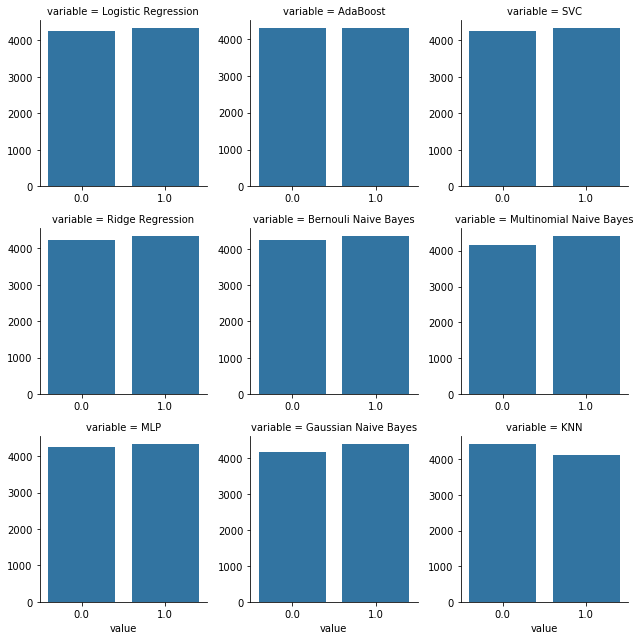

In [350]:
# Visualization and comparison the frequency of predicted match results
all_preds_flat = pd.melt(pd.DataFrame.from_dict(clfs_preds))
g = sns.FacetGrid(all_preds_flat, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')
plt.show()

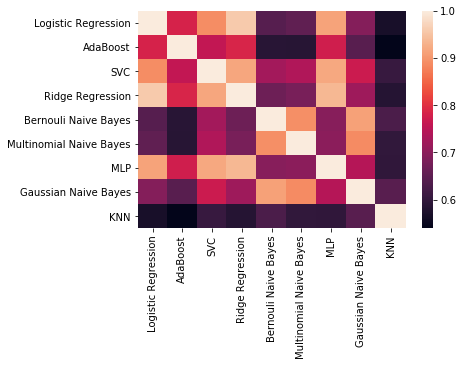

In [351]:
# Visualization of correlation between individual classifiers

preds_df = pd.DataFrame.from_dict(clfs_preds)
sns.heatmap(preds_df.corr())
plt.show()

Particular classifiers provide different information, combining them into a stacked model can give promising results.

The above heatmap shows that it is not profitable to use eg Logistic Regression and Ridge Regression as an additional column in the stacked model. This can lead to overfitting.

### Model Stacking

Our meta classifier will be XGBClassifier. First layer classifiers we trained in the previous section and now choose the least correlated.

We add classifiers predictions to the original training dataset:

In [403]:
test_props = {}

for (clf_n, clf) in clfs.items():
    if clf_n != 'Ridge Regression':
        test_props[clf_n] = clf.predict_proba(X_test)
        clfs_props[clf_n] = clf.predict_proba(X_train)
    else:
        test_props[clf_n] = clf.predict(X_test)
        clfs_props[clf_n] = clf.predict(X_train)

for (clf_n, clf) in clfs.items():
    if test_props[clf_n].size == 2*X_test.shape[0]:
        test_props[clf_n] = test_props[clf_n][:,0]
    if clfs_props[clf_n].size == 2*X_train.shape[0]:
        clfPoniższe wyniki są przy zastosowaniu wszystkich klasyfikatorów w 1. warstwie, widać tutaj ewidentnie overfitting, bardzo szybko osiągamy 99% accuracy na  zbiorze uczącym, ale na testowym mamy  < 70%s_props[clf_n] = clfs_props[clf_n][:,0]

# Bad idea
test_props_dfALL = pd.DataFrame.from_dict(test_props)
props_dfALL = pd.DataFrame.from_dict(clfs_props)

X_testALL = X_test.copy()
X_trainALL = X_train.copy()
X_testALL.reset_index(drop=True, inplace=True)
X_trainALL.reset_index(drop=True, inplace=True)
test_props_dfALL.reset_index(drop=True, inplace=True)
props_dfALL.reset_index(drop=True, inplace=True)

X_te_extendedALL = X_testALL.join(test_props_dfALL)
X_tr_extendedALL = X_trainALL.join(props_dfALL)

# We want to avoid overfitting, we add the least correlated classifiers
active_clfs = ['Logistic Regression', 'KNN', 'Gaussian Naive Bayes', 'MLP', 'AdaBoost']

for (clf_n, clf) in clfs.items():
    if clf_n not in active_clfs:
        del test_props[clf_n]
        del clfs_props[clf_n]

test_props_df = pd.DataFrame.from_dict(test_props)
props_df = pd.DataFrame.from_dict(clfs_props)

X_test.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
test_props_df.reset_index(drop=True, inplace=True)
props_df.reset_index(drop=True, inplace=True)

X_te_extended = X_test.join(test_props_df)
X_tr_extended = X_train.join(props_df)

### Bayesian optimization over hyper parameters

The search space may turn out to be too large or too little precise. Instead of GridSearch we will use Bayesian Optimazation:

In [455]:
bayes_cv_tuner = BayesSearchCV(
    estimator = XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (1, 6),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 0.8, 'uniform'),
        'colsample_bylevel': (0.01, 0.8, 'uniform'),
        'reg_lambda': (1e-9, 1000.0, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 140),
        'scale_pos_weight': (1e-6, 500.0, 'log-uniform')
    },    
    scoring = 'accuracy',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 12,
    n_iter = 10,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))


The following results are used with all classifiers in the 1st layer, you can clearly see overfitting here, we achieve 99% accuracy very quickly on the training set, but on the test set we have <70%: 

In [405]:
result = bayes_cv_tuner.fit(X_tr_extendedALL.values, y_train.values, callback=status_print)

Model #1
Best: 0.9887
Best params: OrderedDict([('colsample_bylevel', 0.2724665336661209), ('colsample_bytree', 0.4757444756334881), ('gamma', 0.13031389926541354), ('learning_rate', 0.042815319280763466), ('max_delta_step', 13), ('max_depth', 3), ('min_child_weight', 2), ('n_estimators', 89), ('reg_alpha', 5.497557739289786e-07), ('reg_lambda', 0.05936070635912049), ('scale_pos_weight', 0.060830282487222144), ('subsample', 0.13556548021189216)])

Model #2
Best: 0.9922
Best params: OrderedDict([('colsample_bylevel', 0.545928547554102), ('colsample_bytree', 0.5753217775237519), ('gamma', 4.358684608480795e-07), ('learning_rate', 0.7988179462781242), ('max_delta_step', 17), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 58), ('reg_alpha', 0.0005266983003701547), ('reg_lambda', 276.5424475574225), ('scale_pos_weight', 0.3016410771843142), ('subsample', 0.9923710598637134)])

Model #3
Best: 0.9922
Best params: OrderedDict([('colsample_bylevel', 0.545928547554102), ('colsample_

/home/maurykdell/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [406]:
model = XGBClassifier(**bayes_cv_tuner.best_params_)

In [407]:
model.fit(X_tr_extendedALL.values,y_train.values)

[20:26:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.4049307894414825, colsample_bynode=1,
              colsample_bytree=0.5062332024498448, gamma=1.3277909848852635e-06,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.5605967693796124, max_delta_step=12, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=64, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0.004026635957416632, reg_lambda=0.040887904512512056,
              scale_pos_weight=109.72255122430063, subsample=0.6612742297240571,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [409]:
predictions = model.predict(X_te_extendedALL.values)
acc = accuracy_score(y_test, predictions)
print(acc)

0.6862615587846763


Here are our final results, the selection of the Bayesian Optimizer search space was done experimentally. The most important (to avoid overfitting), it turned out: *max_depth*, *n_estimators* and *colsample_bytree*:

In [456]:
result = bayes_cv_tuner.fit(X_tr_extended.values, y_train.values, callback=status_print)

Model #1
Best: 0.5293
Best params: OrderedDict([('colsample_bylevel', 0.333982127494118), ('colsample_bytree', 0.5849033371100868), ('gamma', 0.13031389926541354), ('learning_rate', 0.042815319280763466), ('max_delta_step', 13), ('max_depth', 3), ('min_child_weight', 2), ('n_estimators', 117), ('reg_alpha', 5.497557739289786e-07), ('reg_lambda', 0.05936070635912049), ('scale_pos_weight', 0.060830282487222144), ('subsample', 0.13556548021189216)])

Model #2
Best: 0.6465
Best params: OrderedDict([('colsample_bylevel', 0.6715368008870947), ('colsample_bytree', 0.7078190691308812), ('gamma', 4.358684608480795e-07), ('learning_rate', 0.7988179462781242), ('max_delta_step', 17), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 82), ('reg_alpha', 0.0005266983003701547), ('reg_lambda', 276.5424475574225), ('scale_pos_weight', 0.3016410771843142), ('subsample', 0.9923710598637134)])

Model #3
Best: 0.7114
Best params: OrderedDict([('colsample_bylevel', 0.36141768471790997), ('colsamp

/home/maurykdell/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [457]:
model = XGBClassifier(**bayes_cv_tuner.best_params_)

In [458]:
model.fit(X_tr_extended.values,y_train.values)

[20:39:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.36141768471790997, colsample_bynode=1,
              colsample_bytree=0.7357907921188079, gamma=8.168958221061441e-09,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.07356404539935663, max_delta_step=4, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=118, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0.00010376808625045426, reg_lambda=476.96194787286544,
              scale_pos_weight=1.3165669602830552, subsample=0.387658500562527,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [459]:
predictions = model.predict(X_te_extended.values)
acc = accuracy_score(y_test, predictions)
print(acc)

0.7219286657859973


## Conclusions

League of Legends is an esports game, so it would be strange if the result of the game could be decided in its first period (10 minutes). Perhaps, it would be possible to reach 74% +/- 1% (such best results were achieved by others on similar data).


This project taught us a lot to handle data, analyze it and collect it, we are most satisfied with our results, more about the data analysis and results in the second notebook.